# Nowcasting US GDP

In [164]:
import pandas as pd
import numpy as np
from fredapi import Fred
import yaml
import wrds
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

warnings.simplefilter('ignore')

DATA_DIR = '../data/'
OUTPUT_DIR = '../output/'

with open(r'%sapi_key.yaml' %DATA_DIR) as file: 
    api_key = yaml.load(file, Loader=yaml.FullLoader)['api_key']
    
fred = Fred(api_key=api_key)

db=wrds.Connection(wrds_username='kamransattary')

Loading library list...
Done


Exception during reset or similar
Traceback (most recent call last):
  File "/home/kamran/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 693, in _finalize_fairy
    fairy._reset(pool)
  File "/home/kamran/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/home/kamran/anaconda3/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 538, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: SSL connection has been closed unexpectedly



In [ ]:
all_common_stocks = db.raw_sql("SELECT a.permno, a.date, b.shrcd, b.exchcd, a.ret, a.prc, a.shrout"
                                " FROM crsp.msf AS a LEFT JOIN crsp.msenames as b"
                                " ON a.permno=b.permno AND b.namedt<=a.date AND a.date<=b.nameendt"
                                " WHERE b.shrcd in (10,11) AND b.exchcd in (1,2)"
                                " AND a.date >='1980-01-01' AND a.date <='2019-12-31'"
                                )
all_common_stocks['market_cap'] = np.abs(all_common_stocks['prc']) * all_common_stocks['shrout']

def round_datetime(date):
    '''round a given date to the first of the current month'''
    return pd.to_datetime(str(date)[:7])
all_common_stocks['date'] = all_common_stocks['date'].map(round_datetime)
# top 20 market-cap stocks end of 2019
top20 = all_common_stocks.loc[all_common_stocks['date']=='2019-12-01'].sort_values('market_cap', ascending=False)[:20].permno
top20_ts = all_common_stocks.loc[all_common_stocks.permno.isin(top20)].pivot_table(values='ret', columns='permno', index='date')

In [ ]:
chosen_indicators = {'GDP':'earliest_available', #GDP
                     'SP500':'1_month_lag', #SP500
                     'EXPGSC1':'earliest_available', #EXP G&S
                     'IMPGSC1':'earliest_available', #IMP G&S
                     'USAPFCEQDSMEI':'earliest_available', #Private Consumption
                     'DEXUSEU':'1_month_lag', #Exchange Rate USD EUR
                     'UNRATE':'earliest_available', #Unemployment 
                     'LMJVTTUVUSM647S':'earliest_available', #Job vacancies
                     'PRS30006042':'earliest_available', #Manufacturing Sector: Real Output
                     'WM2NS':'1_month_lag', #M2 Money Stock (WM2NS)
                     'NASDAQ100':'1_month_lag', #NASDAQ 100 Index (NASDAQ100)
                     'RVXCLS':'1_month_lag', #CBOE Russell 2000 Volatility Index (RVXCLS)
                     'GFDEBTN':'earliest_available', #Federal Debt: Total Public Debt (GFDEBTN)
                     'NIKKEI225':'1_month_lag', #Nikkei Stock Average, Nikkei 225 (NIKKEI225)
                     'IRLTLT01USM156N':'1_month_lag', #Long-Term Government Bond Yields: 10-year: Main (Including Benchmark) for the United States (IRLTLT01USM156N)
                    }

# """
# Dax - cant find
# eurostoxx - cant find
# ftse 100
# hang seng
# """

In [ ]:
def clean_data(chosen_indicators, impute_method):
    
    final = top20_ts.copy()
    for indicator in chosen_indicators.keys():
        
        if chosen_indicators[indicator] == 'earliest_available':
            temp = fred.get_series_all_releases(indicator).dropna().sort_values('realtime_start')
            temp = temp[~temp.date.dt.date.duplicated()]
            temp = temp.loc[temp.realtime_start > '1999-12-01']
            temp['value'] = temp['value'].diff(periods=1) ##
            temp['date'] = temp['date'].map(round_datetime)
            temp = temp.set_index('date')
            
            final = final.merge(temp['value'].to_frame(indicator), left_index=True, right_index=True, how='left')
                        
        if chosen_indicators[indicator] == '1_month_lag':
            temp = fred.get_series(indicator).resample('M').mean().shift(1).dropna()
            temp.index = temp.index.map(round_datetime)
            
            final = final.merge(temp.to_frame(indicator), left_index=True, right_index=True)
    
    return final

In [145]:
series = clean_data(chosen_indicators)

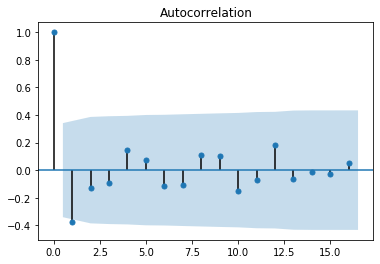

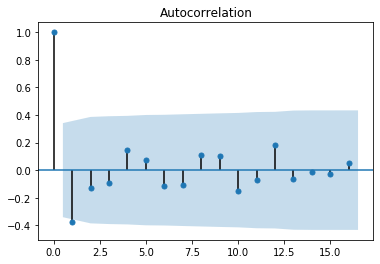

In [146]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series['GDP'].dropna().diff(periods=1).dropna())

In [148]:
data = np.asarray(series.GDP).astype('float')
import warnings

warnings.simplefilter('ignore')

# Iterate over all ARMA(p,q) models with p,q in [0,6]
best_p, best_q = 0,0
best_aic = np.inf
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with missing datapoints
        mod = sm.tsa.statespace.SARIMAX(data, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            if best_aic > res.aic and res.aic>0: 
                best_p, best_q, best_aic = p, q, res.aic
        except:
            continue
            
mod = sm.tsa.statespace.SARIMAX(data, order=(best_p,0,best_q), enforce_invertibility=False)
res = mod.fit(disp=False)

# In-sample one-step-ahead predictions
predict = res.get_prediction(end=mod.nobs).predicted_mean

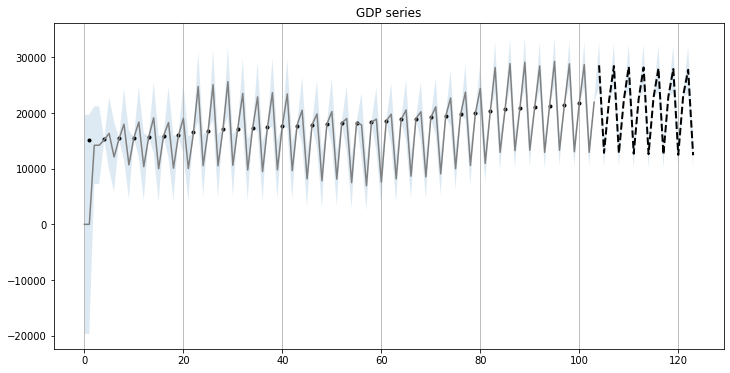

In [115]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
#https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_internet.html
nforecast = 20
predict = res.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data, 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

ax.set(title='GDP series');

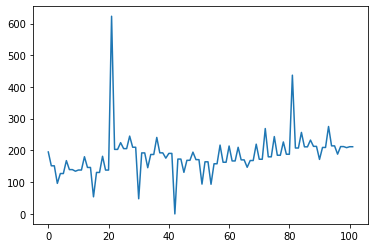

In [155]:
data[np.where(np.isnan(data))[0]] = predict[np.where(np.isnan(data))[0]].tolist()
data = data[1:]
plt.plot(data)

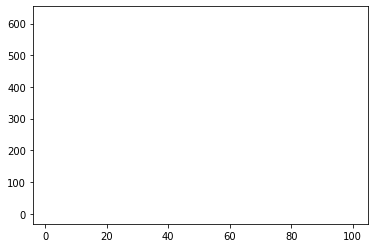

In [153]:
plt.plot(np.asarray(series.GDP.dropna()).astype('float'))